In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Normalize((mean),(std)) the images
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [3]:
# Loading training and testing datasets
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# The trainset shape is 4 x 3 x 32 x 32
# 4 images at once (batch size), 3 channels and each image is 32 x 32
print('Shape of each image : {}'.format(trainset[0][0].shape))
print(trainset[0][0][0][0])

Shape of each image : torch.Size([3, 32, 32])
tensor([-0.5373, -0.6627, -0.6078, -0.4667, -0.2314, -0.0667,  0.0902,  0.1373,
         0.1686,  0.1686,  0.0275, -0.0196,  0.1137,  0.1294,  0.0745,  0.0118,
         0.0745,  0.0510, -0.0275,  0.0902,  0.0902,  0.0431,  0.0667,  0.0902,
         0.1922,  0.2784,  0.3176,  0.2471,  0.2392,  0.2392,  0.1922,  0.1608])


In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image):
    # unnormalize the image
    # divide by 2 (1 / std)->(1/0.5=2), add mean
    image = image / 2 + 0.5
    npimage = image.numpy()
    # the image is 3 x 32 x 32 so we will change to 32 x 32 x 3
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimage, (1,2,0)))
    plt.show()

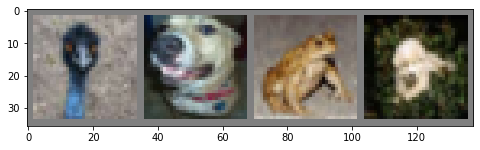


 bird   dog  frog   dog 


In [7]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s ' % classes[labels[j]] for j in range(4)))

In [8]:
class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn_model = torch.nn.Sequential(
            # (input_channels, output_channels, filter_size)
            torch.nn.Conv2d(3, 6, 5), # (4,3,32,32) -> (4,6,28,28)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2), # (4,6,30,30) -> (4,6,14,14)
            torch.nn.Conv2d(6, 16, 5), # (4,6,14,14) -> (4,16,10,10)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2) # (4,16,10,10) -> (4,16,5,5)
        )
        self.fc_model = torch.nn.Sequential(
            torch.nn.Linear(400,120), # (16*5*5) -> (120)
            torch.nn.ReLU(),
            torch.nn.Linear(120,84), # (120) -> (84)
            torch.nn.ReLU(),
            torch.nn.Linear(84,10)
        )

    def forward(self,x):
        #print(x.shape) (4,3,32,32)
        x = self.cnn_model(x)
        #print(x.shape) (4,16,5,5)
        x = x.view(x.size(0),-1) # flatten into a single layer
        #print(x.shape) (4,400)
        x = self.fc_model(x)
        #print(x.shape) (4,10)
        return x 



In [9]:
net = LeNet()
output = net(images)

In [10]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
for epoch in range(2):

    running_loss = 0.0
    for i,data in enumerate(trainloader,0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs) # forward propagation
        loss = loss_function(outputs,labels) # loss function
        loss.backward() # backward propagation
        optimizer.step() # update parameters

        running_loss += loss.item()

        if i%2000 == 1999:
            # prints loss value after batch size of 2000
            print('Epoch : %d, Batch : %5d, Loss : %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print('\n-----\nEnd of Training\n----\n')            

Epoch : 1, Batch :  2000, Loss : 2.228
Epoch : 1, Batch :  4000, Loss : 1.901
Epoch : 1, Batch :  6000, Loss : 1.672
Epoch : 1, Batch :  8000, Loss : 1.577
Epoch : 1, Batch : 10000, Loss : 1.530
Epoch : 1, Batch : 12000, Loss : 1.478
Epoch : 2, Batch :  2000, Loss : 1.417
Epoch : 2, Batch :  4000, Loss : 1.389
Epoch : 2, Batch :  6000, Loss : 1.361
Epoch : 2, Batch :  8000, Loss : 1.325
Epoch : 2, Batch : 10000, Loss : 1.303
Epoch : 2, Batch : 12000, Loss : 1.302

-----
End of Training
----



In [12]:
# Accuracy on test set
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of network on test set : %d %%' %(100 * correct/total))        

Accuracy of network on test set : 55 %


In [13]:
# Accuracy of individual classes on test set
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i]/class_total[i]))            


Accuracy of plane : 59 %
Accuracy of   car : 45 %
Accuracy of  bird : 48 %
Accuracy of   cat : 39 %
Accuracy of  deer : 41 %
Accuracy of   dog : 42 %
Accuracy of  frog : 73 %
Accuracy of horse : 64 %
Accuracy of  ship : 61 %
Accuracy of truck : 73 %
